# Breast Cancer Images Classification


![](https://ars.els-cdn.com/content/image/1-s2.0-S1574789110000268-gr1.jpg)

## Problem Introduction:
This notebook is concerned with classifying images using the **BreakHis** (Breast Cancer Histopathological Image Dataset). Breast cancer is a disease seen mainly in women and is seen as a major cause of death among women. In 2018, the total deaths due to breast cancer in women was seen to be **627,000** out of **2.1 million** cases which were diagnosed. **Invasive Ductual Carcinoma (IDC)** in diagnosing breast cancer, since its subsequent digitalization is more feasible due to advancements in slide scanning technology, as well as the reduction of storage load cost in recent years. The digitialized approcches in deep learning has aided a lot in diagnosing and controlling breast cancer, with power to pre-identify the disease via deep learning methods. 

## Dataset Information 
The breast cancer histopathological image dataset (BreakHis) contains **9109** microscopic images of breast tumor tissues collected from **82** patients, regarded as malignant or benign. The tissues are magnigfied at different scaling factors (**40X**, **100X**, **200X**, **400X**). In this dataset, it contains **2480** malignant and **5429** benign tumors. The images of tissues are taken to be **700X460 pixels**, **3-channel RGB**, **8** bit depth in each format, and in PNG. It is believed that this dataset can become a benchmark for future classifications of breast cancer classification.        

## Import Python Libraries

In [1]:
# importing libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, time, tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import *
import tensorflow as tf 
from functools import partial
from tensorflow.keras import layers
import albumentations as A
import tensorflow_hub as hub
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import classification_report, f1_score

## GPU Confirmation

Let's make sure that we have a GPU installed. 

In [2]:
!nvidia-smi

Sun Oct  3 22:09:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 471.96       Driver Version: 471.96       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A    0C    P0    16W /  N/A |    121MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Loading the Dataset

First, we load the data that contains multiple files, one file contains the information anout all images in a csv format, and there is another directory that contains the information about the images of breast cancer tissues.   

In [3]:
image_dir = '../Data/BreaKHis_v1/'
data_path = '../Data/Folds.csv'

# experimental API for making data pipelines
tf.data.experimental.AUTOTUNE

# defining the class names
class_names = ['malignant', 'benign']

In [4]:
# loading the data
data = pd.read_csv(data_path)
data.head(5)

,fold,mag,grp,filename
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...


### Data Structuring
We will strcuture the data in csv filefor our ease and for better understanding. 

In [5]:
# renaming and structuring the columns for better understanding
data = data.rename(columns={'filename': 'path'})
data['label'] = data.path.apply(lambda x: x.split('/')[3])
data['label_int'] = data.label.apply(lambda x: class_names.index(x))
data['filename'] = data.path.apply(lambda x: x.split('/')[-1])

In [6]:
# view first n rows of strucrured data
data.head(6)

,fold,mag,grp,path,label,label_int,filename
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-001.png
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-002.png
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-003.png
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-004.png
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-005.png
5,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-006.png


In [7]:
data.shape

(39545, 7)

Our dataset has been restructured the way we wanted it to be. Let's perform some analysis on it tnd then we will move towards the images to perform computations on them. 

## Analysis on Data

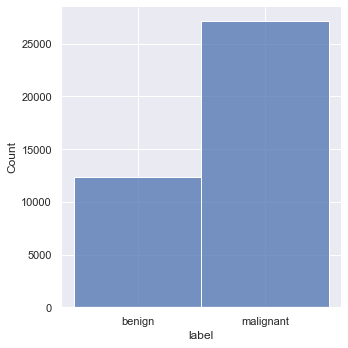

In [8]:
# making a plot to see data distribution
# sns.figure()
sns.set_theme()
sns.displot(x='label', data=data)

The graph sows that most of the samples in our data have malignant tumors, and less have benign tumors

<AxesSubplot:xlabel='label', ylabel='count'>

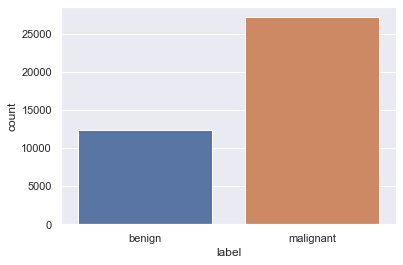

In [9]:
sns.countplot(x=data['label'], data=data)

## Dataset Modelling for Deep Learning

We will model the data for our training, vaidation and testing sets. 

In [10]:
# sorting out training, validation and testing images
test_images = data.groupby(by='label').sample(4000)
train_images = data.drop(test_images.index).reset_index(drop=True)
test_images = test_images.reset_index(drop=True)

In [11]:
# making splits of training & validation datasets
validation_images = train_images.sample(frac = 0.2)
train_images = train_images.drop(validation_images.index).reset_index(drop=True)
validation_images = validation_images.reset_index(drop=True)

In [12]:
print('Total training images: % s' % str(train_images.shape[0]))
print('Total validation images: % s' % str(validation_images.shape[0]))
print('Total testing images: % s' % str(test_images.shape[0]))

Total training images: 25236
Total validation images: 6309
Total testing images: 8000


In [13]:
train_images['set'] = 'train'
validation_images['set'] = 'validation'
test_images['set'] = 'test'

In [14]:
new_data = pd.concat([train_images, validation_images, test_images])
new_data.head(5)

,fold,mag,grp,path,label,label_int,filename,set
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-001.png,train
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-002.png,train
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-003.png,train
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-004.png,train
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-006.png,train


### Visualizing Train, Validation & Test Splits

<AxesSubplot:xlabel='label', ylabel='count'>

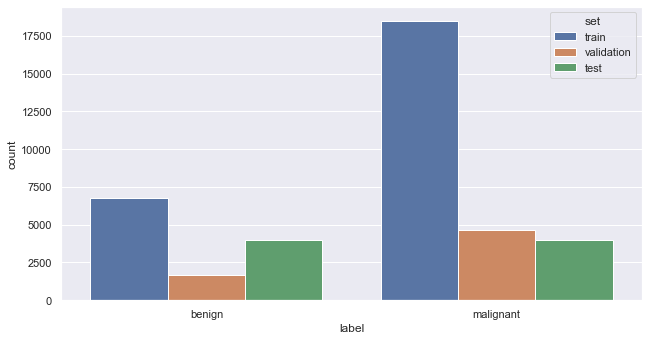

In [15]:
sns.set(rc={'figure.figsize':(10.4, 5.4)})
sns.countplot(x=new_data['label'], hue=new_data['set'])

## Unsampling Data

In [16]:
max_count = np.max(train_images.label.value_counts())
min_count = np.min(train_images.label.value_counts())
train_images = train_images.groupby('label').sample(n=max_count, replace=True)
train_images = train_images.reset_index(drop=True)

In [17]:
train_images.head(5)

,fold,mag,grp,path,label,label_int,filename,set
0,1,40,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_F-14-21998EF-40-005.png,train
1,3,40,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_PT-14-21998AB-40-007.png,train
2,4,40,test,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_PT-14-22704-40-034.png,train
3,2,200,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549CD-200-004.png,train
4,5,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_F-14-21998EF-100-021.png,train


## Making the Deep Learning Model

In [18]:
model_handle_map = {"efficientnetv2-b0": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2", 
                   "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4"}
model_image_size = {"efficientnetv2-b0": 224, 
                   "inception_v3": 299}

In [19]:
# function to decode a PNG image into a tf tensor
def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.io.decode_png(image, channels=3)
    return image, label

# reshaping the image between 0 and 1
def image_reshape(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [224, 224] / 255)
    return image, label

# image argumentation for faster model training
def argument_image(image):
    transform = A.Compose([A.HorizontalFlip(p = 0.5), 
                          A.Rotate(p = 0.5, limit = 15), 
                          A.RandomBrightnessContrast(p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.1, 0.1), 
                                                    brightness_by_max=True),
                           A.RandomResizedCrop(p=0.8, height=IMG_SIZE, width=IMG_SIZE, 
                                              scale=(0.9, 1.1), ratio=(0.05, 1.1), interpolation=0),
                           A.Blur(blur_limit = (1, 1))
                           
                          ])
    
    data = {"image": image}
    argumented_data = transform(**data)
    argumented_image = argumented_data["image"]
    argumented_image = tf.cast(argumented_image, tf.float32)
    argumented_image = tf.image.resize(argumented_image, [IMG_SIZE, IMG_SIZE]) / 255
    
    return argumented_image

def argumentor_function(image, label):
    argumented_image = tf.numpy_function(func = argument_image, inp=[image], Tout = tf.float32)
    return argumented_image, label


# function to view sample of images
def view_image(ds, col = 8, row = 2, size=(25, 10)):
    plt.figure(figsize=(10, 5))
    plt.subplots_adjust(wspace = 0.05, hspace = 0.15)
    for images, labels in ds.take(1):
        for i in range(col * row):
            ax = plt.subplot(row, col, i + 1)
            shape = str(images[i].numpy().shape)
            plt.imshow(images[i].numpy())
            plt.title(class_names[labels[i].numpy()])
            plt.axis("off") 
    plt.tight_layout
    return None

def view_model_predictions():
    plt.figure(figsize = (30, 8))
    plt.rcParams.update({'font.size': 10})
    plt.subplots_adjust(wspace = 0.05, hspace = 0.15)
    for i in range(30):
        ax = plt.subplot(3, 10, i + 1)
        shape = str(test_image[i].numpy().shape)
        plt.imshow(test_image[i].numpy())
        plt.title(predicted_label[i][0])
        plt.axis("off") 
        plt.tight_layout
    return None

# making a function to calculate & show model history
def model_hist(history):
    accuracy = history['accuracy']
    loss = history['loss']
    val_accuracy = history['val_accuracy']
    val_loss = history['val_loss']
    
    # setting the epochs
    n_epochs = range(len(history['loss']))
    
    # saving models logs
    # csv_logger = CSVLogger('cnn_model_logs.csv', append=True)
    
    # making plots for accuracy 
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    plt.plot(n_epochs, accuracy, label='training accuracy')
    plt.plot(n_epochs, val_accuracy, label='validation accuracy')
    plt.legend()
    
    # making plots for loss
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 2)
    plt.plot(n_epochs, loss, label='training loss (binary crossentropy)')
    plt.plot(n_epochs, val_loss, label='validation loss (binary crossentropy)')
    plt.legend()
    
    return None

# function for decoding a test image
def decode_test_img(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [224, 224])
    return image

# function for building a NN
def make_nn_model(image_size):
    print('Making our deep cnn model.....')
    cnn_model = tf.keras.Sequential([
        layers.InputLayer(input_shape=(image_size, image_size, 3)),
        hub.KerasLayer(model_handle, trainable=True, name='base'),
        layers.Dense(512, activation='relu', name='fc1'),
        layers.BatchNormalization(),
        layers.Dropout(0.4, name='dropout'),
        layers.Dense(128, activation='relu', name='fc2'),
        layers.BatchNormalization(),
        # layers.Dropout(0.4, name='dropout2'),
        layers.Dense(1, activation='sigmoid', name='output')
    ], name=model_name)
    
    cnn_model.build((None, image_size, image_size, 3))
    cnn_model.summary()
    print('model built!')
    return cnn_model

In [20]:
# defining model configuration parameters
model_name = "efficientnetv2-b0"
# model_name = "inception_v3"
model_handle = model_handle_map.get(model_name)
IMG_SIZE = model_image_size.get(model_name, 224)
BATCH_SIZE = 64
EPOCHS = 12
sample_size = len(train_images)

print(f"Selected model: {model_name} : {model_handle}")
print(f"Input size of model: {IMG_SIZE}")

Selected model: efficientnetv2-b0 : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2
Input size of model: 224


In [21]:
IMG_SIZE

224

## Loading the Dataset

We have defined the model parameters + configuration in above sections. Now we define and load the dataset in our memory. We will define 2 datasets, train & valid. 

In [22]:
(image_dir + train_images.path)[0]

'../Data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/40X/SOB_B_F-14-21998EF-40-005.png'

In [23]:
# loading the train & validation dataets
load_train = tf.data.Dataset.from_tensor_slices((image_dir + train_images.path, 
                                                train_images.label_int))

load_valid = tf.data.Dataset.from_tensor_slices((image_dir + validation_images.path, 
                                                validation_images.label_int))

In [24]:
load_train

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int64)>

In [25]:
train_dataset = (
                load_train.shuffle(len(train_images))
                .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                .map(partial(argumentor_function), num_parallel_calls=tf.data.experimental.AUTOTUNE)
                .batch(BATCH_SIZE)
                .prefetch(tf.data.experimental.AUTOTUNE)
                )
val_dataset = (
                load_valid.shuffle(len(validation_images))
                .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                .map(partial(argumentor_function), num_parallel_calls=tf.data.experimental.AUTOTUNE)
                .batch(BATCH_SIZE)
                .prefetch(tf.data.experimental.AUTOTUNE)
                )

train_dataset, val_dataset

(<PrefetchDataset shapes: (<unknown>, (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: (<unknown>, (None,)), types: (tf.float32, tf.int64)>)

In [26]:
# checking the path of images
train_images.path[1]

'BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/40X/SOB_B_PT-14-21998AB-40-007.png'

Time Taken: 0.650 seconds


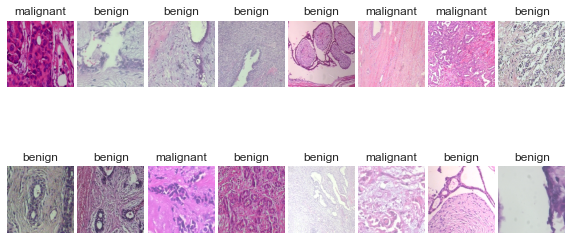

In [27]:
start = time.time()
view_image(train_dataset)
end = time.time()
print('Time Taken: %.3f seconds' % (end-start))

Time Taken: 0.622 seconds


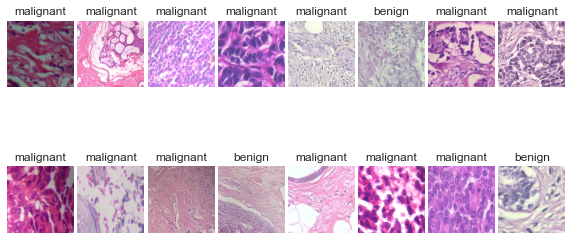

In [28]:
start = time.time()
view_image(val_dataset)
end = time.time()
print('Time Taken: %.3f seconds' % (end-start))

We have successfully loaded the images, preprocessed them, made image argumentations and visualized the images of what they look like. 

## Deep Learning Model Training

This is the step whwre we train our deep learning model. We have defined the model configuration, dataset modelling, data loading and preparation.   

In [29]:
print('Size of Image being used: %d' % IMG_SIZE)

Size of Image being used: 224


In [30]:
# starting a new sesion for TF
image_size = 224
tf.keras.backend.clear_session()
model_nn = make_nn_model(IMG_SIZE)

# making model checkpoints
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', save_best_only=True)

# model logs
csv_logger = CSVLogger('cnn_model_logs.csv', append=True)

metrics = ['accuracy', Precision(name='Precision'), Recall(name='Recall')]

# compiling the model
model_nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)

# fit the model
train_history = model_nn.fit(train_dataset, epochs=10, batch_size=BATCH_SIZE, verbose=1, 
                             callbacks=[model_checkpoint, csv_logger], validation_data=val_dataset)

Making our deep cnn model.....
Model: "efficientnetv2-b0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
base (KerasLayer)            (None, 1280)              5919312   
_________________________________________________________________
fc1 (Dense)                  (None, 512)               655872    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
fc2 (Dense)                  (None, 128)               65664     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
output (Dense)    

## Visualize Model Performance (Loss/Accuracy)

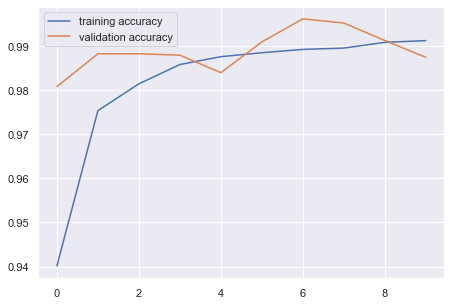

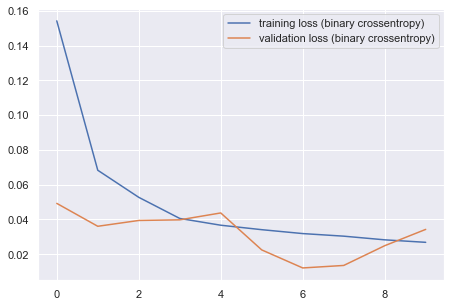

In [31]:
# visualize model performance
history = train_history.history
model_hist(history)

In [32]:
model_nn.evaluate(train_dataset)

578/578 [==============================] - 519s 897ms/step - loss: 0.0198 - accuracy: 0.9930 - Precision: 0.9866 - Recall: 0.9997


[0.019758403301239014,
 0.9930247664451599,
 0.9865528345108032,
 0.9996755719184875]

## Evaluation on Test Data

In [33]:
# making samples of test data
test_images = test_images.sample(frac=1).reset_index(drop=True)
test_data = tf.data.Dataset.from_tensor_slices(image_dir + test_images.path)
test_data = test_data.map(decode_test_img, 
                          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)
test_data

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [34]:
print('Total Test Images: %d' % len(test_images))

Total Test Images: 8000


Test Data Samples have been successfully created!

In [35]:
test_index = test_images.label_int.values
test_labels = test_images.label.values
test_index, test_labels

(array([0, 1, 0, ..., 1, 0, 1], dtype=int64),
 array(['malignant', 'benign', 'malignant', ..., 'benign', 'malignant',
        'benign'], dtype=object))

In [36]:
test_image = next(iter(test_data))

In [37]:
# making predictions
test_predictions = model_nn.predict(test_data)
predicted_index = np.round(test_predictions)

In [38]:
# checking predictions made by neural network
predicted_index[:6]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [39]:
predicted_index = np.round(test_predictions).astype(int)
predicted_label = np.array(class_names)[predicted_index]
predicted_label[:8]

array([['malignant'],
       ['malignant'],
       ['malignant'],
       ['malignant'],
       ['malignant'],
       ['malignant'],
       ['malignant'],
       ['malignant']], dtype='<U9')

In [40]:
prediction_data = pd.DataFrame({'filename':test_images.filename.values,'actual':test_images.label.values, 
                              'prediction': np.squeeze(predicted_label),'path':test_images.path.values,})

In [41]:
# see model predictions
prediction_data[['actual', 'prediction']].head(15)

,actual,prediction
0,malignant,malignant
1,benign,malignant
2,malignant,malignant
3,benign,malignant
4,malignant,malignant
5,malignant,malignant
6,benign,malignant
7,malignant,malignant
8,benign,malignant
9,benign,malignant
